# Import Libraries

In [ ]:
%%capture
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


# Package Installing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import Dataset

In [ ]:
product_data = pd.read_csv('/content/mydrive/MyDrive/Dataset/flipkart_com-ecommerce_sample.csv')

In [ ]:
product_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [ ]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [ ]:
print(product_data.description[1000])

Key Features of INDRICKA Casual Roll-up Sleeve Solid Women's Top Red,INDRICKA Casual Roll-up Sleeve Solid Women's Top Price: Rs. 2,309 INDRICKA presents this Red colured tunic, an apt pick for women who are slightly on the plumper side. This elbow-sleeved dress promotes the widely popular notion that you don’t need to be a size zero to look beautiful and wear pretty outfits. Made from cotton, it will ensure you maximum comfort throughout the day. Team it with a pair of wedges to look perfect. This product is Organic and chemical free.,Specifications of INDRICKA Casual Roll-up Sleeve Solid Women's Top Top Details Sleeve Roll-up Sleeve Number of Contents in Sales Package Pack of 1 Fabric 100% Cotton Type Top Neck V-Neck General Details Pattern Solid Ideal For Women's Occasion Casual Fabric Care Mild Wash/Do not Bleach


# EDA

In [ ]:
product_data.product_category_tree.value_counts()

["Jewellery >> Necklaces & Chains >> Necklaces"]                                                                                                                1567
["Jewellery >> Rings"]                                                                                                                                           710
["Automotive >> Accessories & Spare parts >> Car Interior & Exterior >> Car Interior >> Car Mats"]                                                               522
["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]                                                                                                         430
["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]                                                              332
                                                                                                                                                                ... 
["Clothing

In [ ]:
print(product_data.product_category_tree[1])

["Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo..."]


In [ ]:
product_data = product_data[product_data.product_category_tree.str.contains('>>')]

In [ ]:
product_data['product_category_tree'] = product_data.product_category_tree.apply(lambda desc : re.sub(r'[^\w\d\s]', '', desc.split('>>')[0]).strip())

<Axes: >

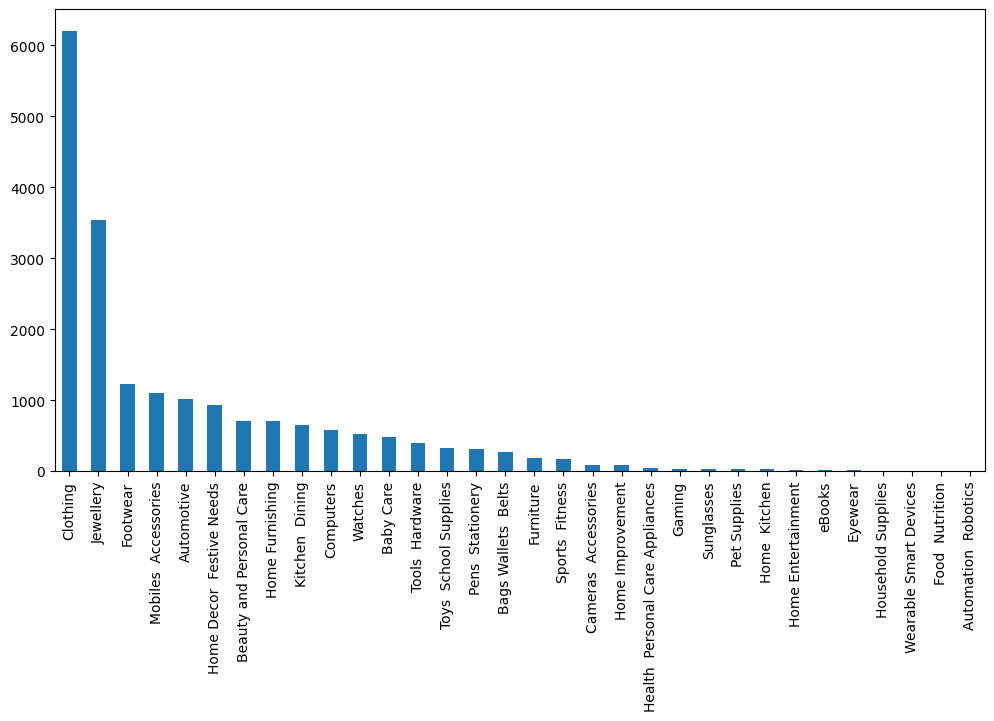

In [ ]:
product_data['product_category_tree'].value_counts().plot(kind = 'bar',
                                                          figsize = (12,6))

# Data Preprocessing

In [ ]:
product_data.isna().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 75
discounted_price             75
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5859
product_specifications       14
dtype: int64

In [ ]:
product_data = product_data.dropna(subset = ['description']).reset_index(drop = True)

In [ ]:
product_data_nlp = product_data[['description', 'product_category_tree']].copy()

In [ ]:
product_data_nlp.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,Specifications of Sicons All Purpose Arnica Do...,Pet Supplies


In [ ]:
product_data_nlp.nunique()

description              17216
product_category_tree       32
dtype: int64

# Text Preprocessing

In [ ]:
def Text_Preprocessing(text) :

  # Remove punctuation
  text = re.sub(r'[^\w\d\s]', ' ', text)
  # Replace whitespace between terms with a single space
  text = re.sub(r'\s+', ' ', text)
  # Remove leading and trailing whitespace
  text = re.sub(r'^\s+|\s+?$', '', text)
  # converting to lower case
  text = text.lower()
  # Replace numbers like price values with 'numbr'
  text = re.sub(r'\d+', '', text)

  return text

In [ ]:
product_data_nlp['description'] = product_data_nlp['description'].apply(Text_Preprocessing)

In [ ]:
general_stopwords = stopwords.words('english')

In [ ]:
def word_tokenizing(text,stop_words):

  tokens = word_tokenize(text)
  return ' '.join([token for token in tokens if token not in stop_words])

In [ ]:
product_data_nlp['description'] = product_data_nlp['description'].apply(lambda text : word_tokenizing(text, general_stopwords))

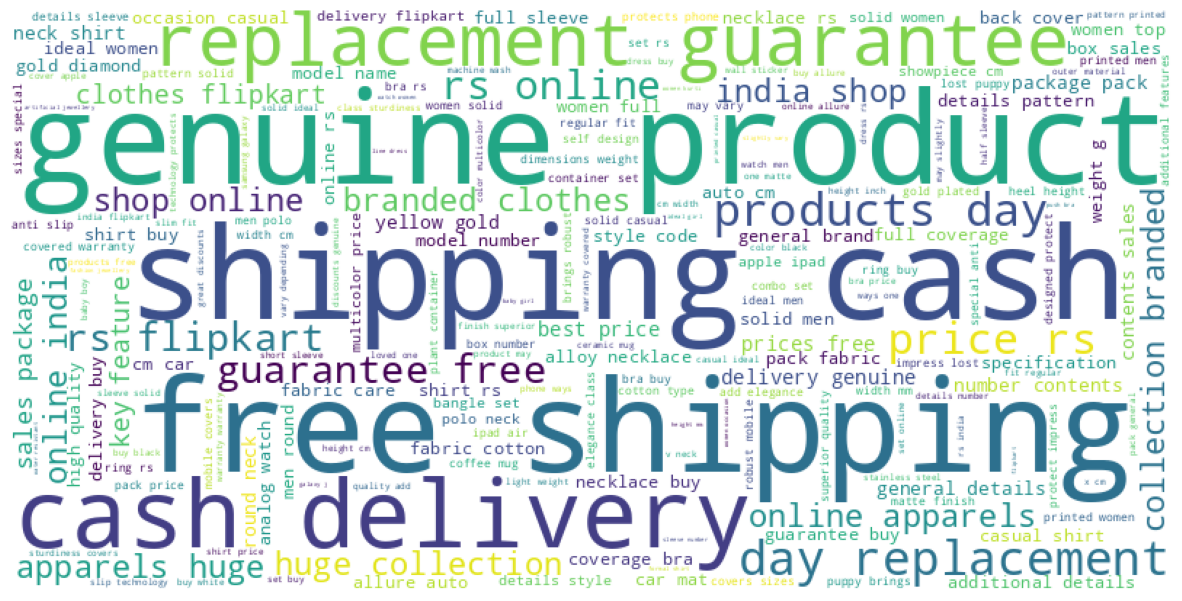

In [ ]:
wordcloud = WordCloud(background_color='white', width = 800, height = 400).generate(' '.join(product_data_nlp.description))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
ecommerce_stopwords = ['ndia', 'line',
    'payment', 'shop', 'size', 'cash', 'checkout', 'free', 'available', 'color', 'tracking', 'promo',
    'day', 'key', 'product', 'customer', 'warranty', 'method', 'genuine', 'com', 'guarantee',
    'price', 'review', 'return', 'exchange', 'replacement', 'flipkart', 'delivery', 'offer', 'deal',
    'cart', 'rating', 'shipping', 'india', 'discount', 'stock', 'brand', 'rs', 'sale', 'shopping',
    'buy', 'order', 'online', 'feature', 'products'
]

In [ ]:
product_data_nlp['description'] = product_data_nlp['description'].apply(lambda text : word_tokenizing(text, ecommerce_stopwords))

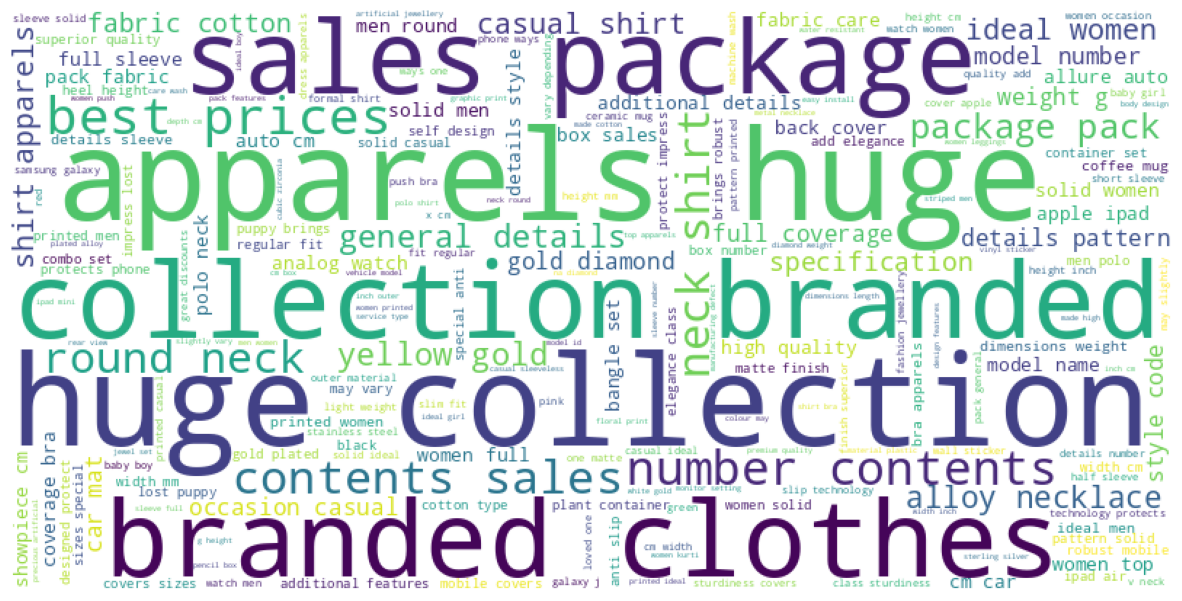

In [ ]:
wordcloud = WordCloud(background_color='white', height=400, width=800).generate(' '.join(product_data_nlp.description))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Feature Engineering

In [ ]:
MAX_LENGTH = 200
product_tokenizer = Tokenizer()
product_tokenizer.fit_on_texts(product_data_nlp['description'])

In [ ]:
vocab_size = len(set(product_tokenizer.word_counts.keys()))

In [ ]:
clean_desc = product_tokenizer.texts_to_sequences(product_data_nlp['description'])

In [ ]:
word_distribution = [len(items) for items in clean_desc]

In [ ]:
sorted([len(items) for items in clean_desc], reverse=True)[:5]

[514, 511, 503, 483, 453]

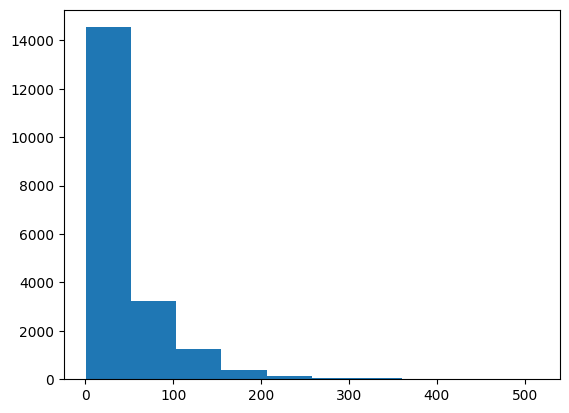

In [ ]:
plt.hist(word_distribution)
plt.show()

In [ ]:
X = pad_sequences(clean_desc, maxlen=MAX_LENGTH)

In [ ]:
# Label Encoder For Target Variable
encoder = LabelEncoder()
y = product_data_nlp['product_category_tree']
encoder.fit(y)
y = encoder.transform(y)

In [ ]:
encoder.classes_

array(['Automation  Robotics', 'Automotive', 'Baby Care',
       'Bags Wallets  Belts', 'Beauty and Personal Care',
       'Cameras  Accessories', 'Clothing', 'Computers', 'Eyewear',
       'Food  Nutrition', 'Footwear', 'Furniture', 'Gaming',
       'Health  Personal Care Appliances', 'Home  Kitchen',
       'Home Decor  Festive Needs', 'Home Entertainment',
       'Home Furnishing', 'Home Improvement', 'Household Supplies',
       'Jewellery', 'Kitchen  Dining', 'Mobiles  Accessories',
       'Pens  Stationery', 'Pet Supplies', 'Sports  Fitness',
       'Sunglasses', 'Tools  Hardware', 'Toys  School Supplies',
       'Watches', 'Wearable Smart Devices', 'eBooks'], dtype=object)

In [ ]:
pd.DataFrame(enumerate(encoder.classes_), columns=['Int Label', 'Str Label'])

,Int Label,Str Label
0,0,Automation Robotics
1,1,Automotive
2,2,Baby Care
3,3,Bags Wallets Belts
4,4,Beauty and Personal Care
5,5,Cameras Accessories
6,6,Clothing
7,7,Computers
8,8,Eyewear
9,9,Food Nutrition


# Train-Test-Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep = '\n')

(14752, 200)
(4918, 200)
(14752,)
(4918,)


In [ ]:
y_train

array([ 7,  6,  6, ...,  6, 21,  6])

In [ ]:
num_class = len(np.unique(y))
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Model Building

## Helper Functions

In [ ]:
def plot_metrics(history) :

  df_metrics = pd.DataFrame(history.history)
  df_metrics['epochs'] = history.epoch
  df_metrics['epochs'] += 1


  plt.figure(figsize = (10, 4))
  ax = plt.subplot(121)
  df_metrics[['epochs', 'loss', 'val_loss']].plot(x = "epochs", grid = True, marker = '.', ms = 12, ax = ax, ylabel = "Loss")
  plt.xticks(ticks = df_metrics['epochs'])
  ax = plt.subplot(122)
  df_metrics[['epochs', 'acc', 'val_acc']].plot(x = "epochs", grid = True, marker = '.', ms = 12, ax = ax, ylabel = "Accuracy")
  plt.xticks(ticks = df_metrics['epochs'])
  plt.show()


## Simple ANN Model

In [ ]:
model_input = Input(shape=(MAX_LENGTH, ))
object_layer = Embedding(vocab_size + 1, 100, input_length = MAX_LENGTH)(model_input)
a = Flatten()(object_layer)
a = Dense(30)(a)
output_layer = Dense(num_class, activation='softmax')(a)
output = Model(inputs = [model_input], outputs = [output_layer])

In [ ]:
output.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
output.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_21 (Embedding)    (None, 200, 100)          1980900   
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense_42 (Dense)            (None, 30)                600030    
                                                                 
 dense_43 (Dense)            (None, 32)                992       
                                                                 
Total params: 2581922 (9.85 MB)
Trainable params: 2581922 (9.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_of_ann = output.fit([X_train], y_train_one_hot, batch_size = 64,
                            verbose = 1, validation_split=.25,
                            shuffle=True, epochs = 10,
                            callbacks = [EarlyStopping(patience=4, restore_best_weights = True)])

Epoch 1/10
173/173 [==============================] - 4s 21ms/step - loss: 1.3312 - acc: 0.6692 - val_loss: 0.6095 - val_acc: 0.8671
Epoch 2/10
173/173 [==============================] - 5s 28ms/step - loss: 0.3565 - acc: 0.9187 - val_loss: 0.3139 - val_acc: 0.9276
Epoch 3/10
173/173 [==============================] - 5s 29ms/step - loss: 0.1509 - acc: 0.9704 - val_loss: 0.2377 - val_acc: 0.9414
Epoch 4/10
173/173 [==============================] - 3s 19ms/step - loss: 0.0737 - acc: 0.9862 - val_loss: 0.2126 - val_acc: 0.9441
Epoch 5/10
173/173 [==============================] - 3s 19ms/step - loss: 0.0414 - acc: 0.9908 - val_loss: 0.2143 - val_acc: 0.9455
Epoch 6/10
173/173 [==============================] - 5s 27ms/step - loss: 0.0267 - acc: 0.9937 - val_loss: 0.2102 - val_acc: 0.9471
Epoch 7/10
173/173 [==============================] - 4s 25ms/step - loss: 0.0181 - acc: 0.9955 - val_loss: 0.2150 - val_acc: 0.9474
Epoch 8/10
173/173 [==============================] - 3s 19ms/step - 

In [ ]:
print('The accuracy score is : ', output.evaluate(X_test, y_test_one_hot)[1])

154/154 [==============================] - 1s 4ms/step - loss: 0.1928 - acc: 0.9490
The accuracy score is :  0.9489629864692688


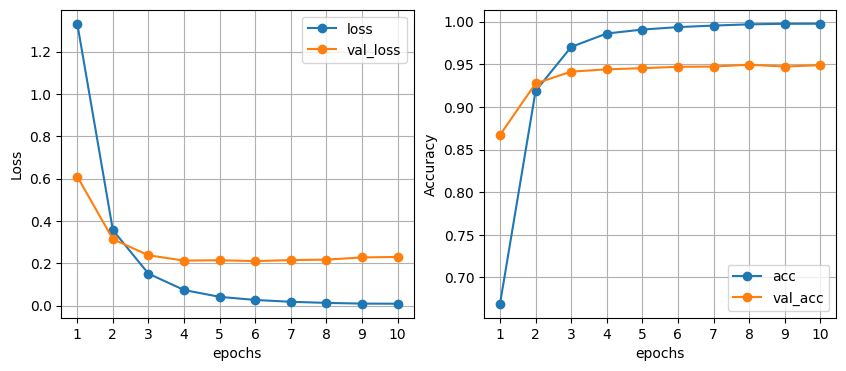

In [ ]:
plot_metrics(history_of_ann)

## LSTM

In [ ]:
model_input = Input(shape = (MAX_LENGTH, ))
object_layer = Embedding(vocab_size + 1, 100, input_length = MAX_LENGTH)(model_input)
a = LSTM(60)(object_layer)
a = Dense(30)(a)
output_layer = Dense(num_class, activation = 'softmax')(a)
output = Model(inputs = [model_input], outputs = [output_layer])

In [ ]:
output.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_22 (Embedding)    (None, 200, 100)          1980900   
                                                                 
 lstm (LSTM)                 (None, 60)                38640     
                                                                 
 dense_44 (Dense)            (None, 30)                1830      
                                                                 
 dense_45 (Dense)            (None, 32)                992       
                                                                 
Total params: 2022362 (7.71 MB)
Trainable params: 2022362 (7.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_of_lstm = output.fit([X_train], y_train_one_hot, batch_size = 64, validation_split=.25,
                             shuffle = True, verbose = 1, epochs = 10,
                             callbacks = [EarlyStopping(patience = 4, restore_best_weights=True)])

Epoch 1/10
173/173 [==============================] - 38s 209ms/step - loss: 1.7244 - acc: 0.5318 - val_loss: 0.9810 - val_acc: 0.7392
Epoch 2/10
173/173 [==============================] - 39s 223ms/step - loss: 0.7208 - acc: 0.8159 - val_loss: 0.5230 - val_acc: 0.8739
Epoch 3/10
173/173 [==============================] - 36s 209ms/step - loss: 0.3832 - acc: 0.8962 - val_loss: 0.3944 - val_acc: 0.9084
Epoch 4/10
173/173 [==============================] - 37s 213ms/step - loss: 0.2431 - acc: 0.9355 - val_loss: 0.3054 - val_acc: 0.9271
Epoch 5/10
173/173 [==============================] - 37s 211ms/step - loss: 0.1720 - acc: 0.9564 - val_loss: 0.2711 - val_acc: 0.9330
Epoch 6/10
173/173 [==============================] - 36s 209ms/step - loss: 0.1293 - acc: 0.9660 - val_loss: 0.2411 - val_acc: 0.9425
Epoch 7/10
173/173 [==============================] - 36s 207ms/step - loss: 0.0988 - acc: 0.9733 - val_loss: 0.2510 - val_acc: 0.9403
Epoch 8/10
173/173 [==============================] - 3

In [ ]:
print('The accuracy score is : ', output.evaluate(X_test, y_test_one_hot)[1])

154/154 [==============================] - 4s 26ms/step - loss: 0.2399 - acc: 0.9431
The accuracy score is :  0.9430662989616394


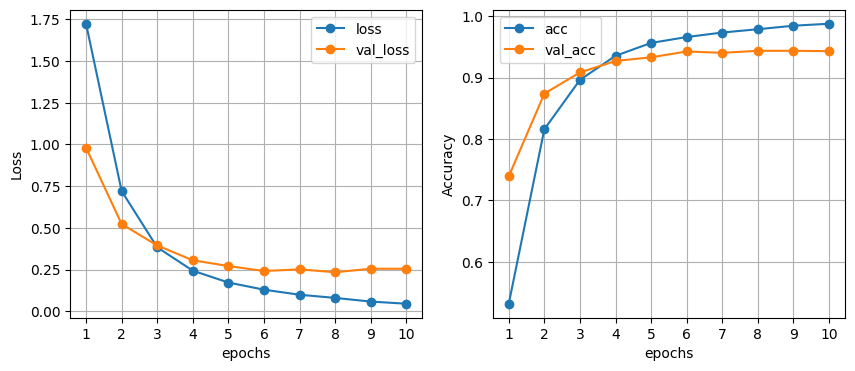

In [ ]:
plot_metrics(history_of_lstm)

## Convolutional Neural Network ( CNN )

In [ ]:
model_input = Input(shape = (MAX_LENGTH, ))
object_layer = Embedding(vocab_size + 1, 100, input_length = MAX_LENGTH)(model_input)
a = Conv1D(60, 10)(object_layer)

a = MaxPooling1D(pool_size = 2)(a)

a = LSTM(60)(a)

a = Dense(30)(a)

output_layer = Dense(num_class, activation = 'softmax')(a)
output = Model(inputs = [model_input], outputs = [output_layer])

In [ ]:
output.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
output.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 200, 100)          1980900   
                                                                 
 conv1d_22 (Conv1D)          (None, 191, 60)           60060     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 95, 60)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dense_48 (Dense)            (None, 30)                1830      
                                                           

In [ ]:
history_of_cnn = output.fit([X_train], y_train_one_hot, validation_split = .25,
                            verbose = 1, shuffle = True, epochs = 10,
                            callbacks = [EarlyStopping(patience = 4, restore_best_weights=True)])

Epoch 1/10
346/346 [==============================] - 51s 143ms/step - loss: 1.2027 - acc: 0.6776 - val_loss: 0.5615 - val_acc: 0.8463
Epoch 2/10
346/346 [==============================] - 48s 138ms/step - loss: 0.3882 - acc: 0.8984 - val_loss: 0.3279 - val_acc: 0.9135
Epoch 3/10
346/346 [==============================] - 45s 130ms/step - loss: 0.2090 - acc: 0.9453 - val_loss: 0.2670 - val_acc: 0.9395
Epoch 4/10
346/346 [==============================] - 46s 132ms/step - loss: 0.1313 - acc: 0.9663 - val_loss: 0.2347 - val_acc: 0.9444
Epoch 5/10
346/346 [==============================] - 47s 135ms/step - loss: 0.0853 - acc: 0.9782 - val_loss: 0.2404 - val_acc: 0.9488
Epoch 6/10
346/346 [==============================] - 46s 134ms/step - loss: 0.0588 - acc: 0.9848 - val_loss: 0.2381 - val_acc: 0.9490
Epoch 7/10
346/346 [==============================] - 45s 129ms/step - loss: 0.0429 - acc: 0.9905 - val_loss: 0.2637 - val_acc: 0.9428
Epoch 8/10
346/346 [==============================] - 4

In [ ]:
print('The accuracy score is : ', output.evaluate(X_test, y_test_one_hot)[1])

154/154 [==============================] - 7s 41ms/step - loss: 0.2631 - acc: 0.9392
The accuracy score is :  0.9392029047012329


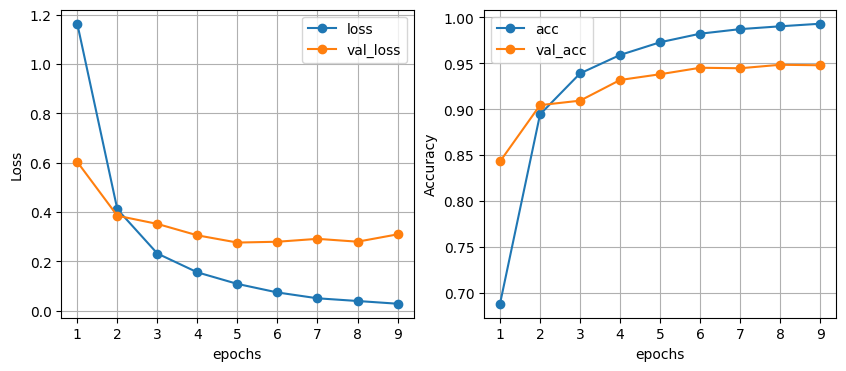

In [ ]:
plot_metrics(history_of_cnn)

## Convolutional Neural Network ( Hyperparameter Tuning )

In [ ]:
def build(num_filters, kernel_size):

  output = Sequential()

  output.add(Embedding(vocab_size + 1, 100, input_length = MAX_LENGTH))
  output.add(Conv1D(num_filters,kernel_size))
  output.add(layers.GlobalMaxPooling1D())
  output.add(Dense(20))
  output.add(Dense(num_class, activation = 'softmax'))
  output.compile(optimizer = 'rmsprop',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
  return output

In [ ]:
params = {
    'num_filters' : [30,60, 100], 'kernel_size' : [4,6,8]
    }

In [ ]:
output = KerasClassifier(build, num_filters =  params['num_filters'],
                         kernel_size = params['kernel_size'])

In [ ]:
rnd_search_cv = RandomizedSearchCV(estimator = output, param_distributions=params, cv =4, verbose = 1, n_iter = 5)
out_result = rnd_search_cv.fit(X_train, y_train_one_hot, epochs = 10, batch_size = 64)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Epoch 1/10
173/173 [==============================] - 14s 66ms/step - loss: 1.5348 - accuracy: 0.6142
Epoch 2/10
173/173 [==============================] - 10s 59ms/step - loss: 0.4363 - accuracy: 0.9017
Epoch 3/10
173/173 [==============================] - 12s 69ms/step - loss: 0.2209 - accuracy: 0.9473
Epoch 4/10
173/173 [==============================] - 10s 56ms/step - loss: 0.1323 - accuracy: 0.9692
Epoch 5/10
173/173 [==============================] - 11s 65ms/step - loss: 0.0838 - accuracy: 0.9804
Epoch 6/10
173/173 [==============================] - 12s 72ms/step - loss: 0.0543 - accuracy: 0.9883
Epoch 7/10
173/173 [==============================] - 11s 65ms/step - loss: 0.0350 - accuracy: 0.9929
Epoch 8/10
173/173 [==============================] - 13s 74ms/step - loss: 0.0221 - accuracy: 0.9958
Epoch 9/10
173/173 [==============================] - 13s 72ms/step - loss: 0.0148 - accuracy: 0.9972
Epoch 10/10
116/116 [=

In [ ]:
print('The accuracy score is : ', out_result.score(X_test, y_test_one_hot))

154/154 [==============================] - 3s 19ms/step
The accuracy score is :  0.9719398129320862


## Accuracy 0.971 🏆 With CNN Hyperparamter Tuning